<a href="https://colab.research.google.com/github/tyganderson/catclassifier-tyganderson/blob/main/pytorch_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment Header
------------------
##### Tyler Anderson <br> University of Hawaii at Manoa <br> ICS 637 <br> Homework 2 <br> February 22, 2023

In [27]:
%matplotlib inline


[Learn the Basics](intro.html) ||
**Quickstart** ||
[Tensors](tensorqs_tutorial.html) ||
[Datasets & DataLoaders](data_tutorial.html) ||
[Transforms](transforms_tutorial.html) ||
[Build Model](buildmodel_tutorial.html) ||
[Autograd](autogradqs_tutorial.html) ||
[Optimization](optimization_tutorial.html) ||
[Save & Load Model](saveloadrun_tutorial.html)

# Quickstart
This section runs through the API for common tasks in machine learning. Refer to the links in each section to dive deeper.

## Working with data
PyTorch has two [primitives to work with data](https://pytorch.org/docs/stable/data.html):
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.


In [28]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch import Tensor
import torch.nn.functional as F

from sklearn import metrics
import numpy as np

PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html),
all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO ([full list here](https://pytorch.org/vision/stable/datasets.html)). In this tutorial, we
use the FashionMNIST dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.



In [29]:
# Unzip our files
# !unzip cat_dog_small.zip
# !unzip cat_dog_full.zip

In [30]:
# Transformation of images used with model
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Directories when using small dataset
small_training = './cat_dog/train'
small_testing = './cat_dog/test'

# Directories when using full dataset
full_training = './dataset/training_set'
full_testing = './dataset/test_set'

# Create variables for our training & testing data
train_data = datasets.ImageFolder(full_training, transform=transform)
test_data = datasets.ImageFolder(full_testing, transform=transform)





We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.



In [31]:
# Determine batch size
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Read more about [loading data in PyTorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), [downloading other datasets](https://pytorch.org/vision/stable/datasets.html), and [creating your own dataset from folders of images](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder).




--------------




## Creating Models
To define a neural network in PyTorch, we create a class that inherits
from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU if available.



In [32]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.convnet = nn.Sequential(
            
            # 1st Conv layer
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3),
                      padding='same', padding_mode='zeros'),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2),

            # 2nd Conv layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3),
                      padding='same', padding_mode='zeros'),
            nn.ReLU(),           
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2),

            # 3rd Conv layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3),
                      padding='same', padding_mode='zeros'),
            nn.ReLU(),           
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2),

            # 4th Conv layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3),
                      padding='same', padding_mode='zeros'),
            nn.ReLU(),           
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2),

            # 5th Conv layer
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3),
                      padding='same', padding_mode='zeros'),
            nn.ReLU(),           
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2),

            # Dense layers
            nn.Flatten(),
            nn.Linear(in_features=1024, out_features=64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=64, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.convnet(x)
        return logits.flatten()



model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (convnet): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.2, inplace=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.2, inplace=False)
    (16): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (17): Re

Read more about [building neural networks in PyTorch](buildmodel_tutorial.html).




--------------




## Optimizing the Model Parameters
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html).



In [33]:
# Loss function
loss_fn = nn.BCELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

# Implement Early Stopping

Here I choose to utilize EarlyStopping from pytorchtools, and create the necessary variables to implement it

In [34]:
# Lists to track training & validation losses for early stopping
train_losses = []
valid_losses = []
avg_train_losses = []
avg_valid_losses = []

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.



In [35]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.float().to(device)
        
        # Compute prediction error
        pred = model(X)
        
        #Calculate loss & append to list
        loss = loss_fn(pred, y)
        train_losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print results periodically during training
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model's performance against the test dataset to ensure it is learning.



In [36]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    y_preds = []
    ys = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.float().to(device)
            
            # Get model prediction
            pred = model(X)
            y_preds.append(pred)

            # Calculate loss of prediction
            loss = loss_fn(pred, y).item()

            # Append loss to validation losses
            valid_losses.append(loss)

            # Append label (y) to list
            ys.append(y)

            # Update average test_loss & correct # count
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()
    
    # Convert array of predictions and actuals to needed format
    y_preds = torch.cat(y_preds)
    y_preds = np.asarray(y_preds.cpu())
    ys = torch.cat(ys)
    ys = np.asarray(ys.cpu())

    # Calculate ROC Curve & AUROC
    fpr, tpr, thresholds = metrics.roc_curve(ys, y_preds)
    auroc = metrics.roc_auc_score(ys, y_preds)

    # Plot ROC Curve & print AUROC
    plt.figure(1)
    plt.plot([0,1], [0,1], 'k-')
    plt.plot(fpr, tpr, label='CNN(area={:.3f}'.format(auroc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    print('AUROC:', auroc)

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.




Epoch 1
-------------------------------
loss: 0.696645  [    0/ 8000]
loss: 0.684341  [ 6400/ 8000]


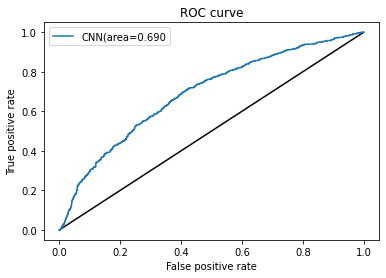

AUROC: 0.6897584999999999
Test Error: 
 Accuracy: 63.4%, Avg loss: 0.645399

Epoch 2
-------------------------------
loss: 0.636430  [    0/ 8000]
loss: 0.605856  [ 6400/ 8000]


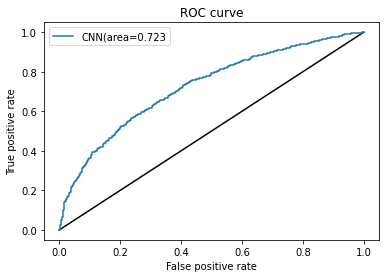

AUROC: 0.7232540000000001
Test Error: 
 Accuracy: 66.0%, Avg loss: 0.620593
Saved PyTorch Model State to model.pth

Epoch 3
-------------------------------
loss: 0.624042  [    0/ 8000]
loss: 0.554986  [ 6400/ 8000]


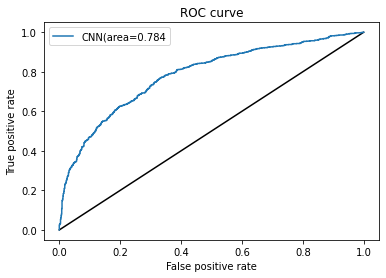

AUROC: 0.783563
Test Error: 
 Accuracy: 69.8%, Avg loss: 0.585597
Saved PyTorch Model State to model.pth

Epoch 4
-------------------------------
loss: 0.551500  [    0/ 8000]
loss: 0.508169  [ 6400/ 8000]


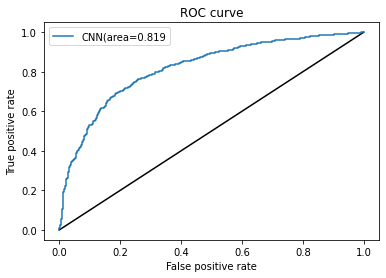

AUROC: 0.818584
Test Error: 
 Accuracy: 75.2%, Avg loss: 0.549468
Saved PyTorch Model State to model.pth

Epoch 5
-------------------------------
loss: 0.588132  [    0/ 8000]
loss: 0.491407  [ 6400/ 8000]


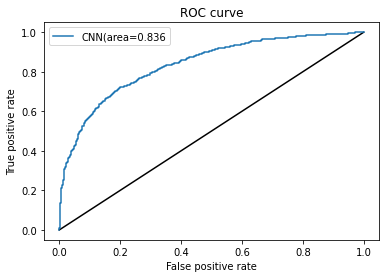

AUROC: 0.8360129999999999
Test Error: 
 Accuracy: 74.0%, Avg loss: 0.533781
Saved PyTorch Model State to model.pth

Epoch 6
-------------------------------
loss: 0.548083  [    0/ 8000]
loss: 0.654913  [ 6400/ 8000]


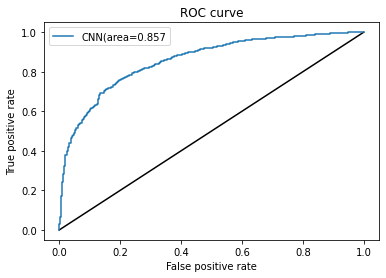

AUROC: 0.8567569999999999
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.484180
Saved PyTorch Model State to model.pth

Epoch 7
-------------------------------
loss: 0.692679  [    0/ 8000]
loss: 0.512682  [ 6400/ 8000]


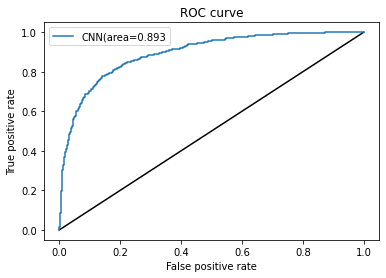

AUROC: 0.893442
Test Error: 
 Accuracy: 81.3%, Avg loss: 0.429788
Saved PyTorch Model State to model.pth

Epoch 8
-------------------------------
loss: 0.456116  [    0/ 8000]
loss: 0.524485  [ 6400/ 8000]


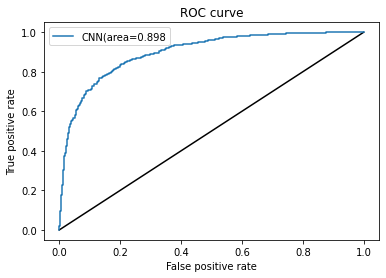

AUROC: 0.8976250000000001
Test Error: 
 Accuracy: 81.8%, Avg loss: 0.419268
Saved PyTorch Model State to model.pth

Epoch 9
-------------------------------
loss: 0.471348  [    0/ 8000]
loss: 0.436298  [ 6400/ 8000]


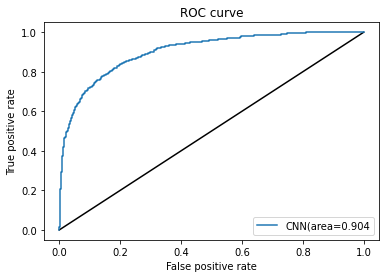

AUROC: 0.903611
Test Error: 
 Accuracy: 80.2%, Avg loss: 0.415300
Saved PyTorch Model State to model.pth

Epoch 10
-------------------------------
loss: 0.364056  [    0/ 8000]
loss: 0.430593  [ 6400/ 8000]


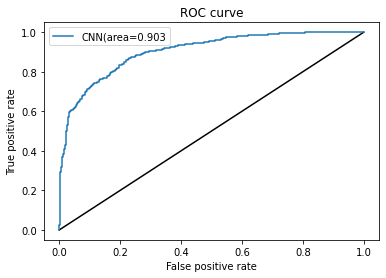

AUROC: 0.9033640000000001
Test Error: 
 Accuracy: 80.2%, Avg loss: 0.435384

Epoch 11
-------------------------------
loss: 0.483043  [    0/ 8000]
loss: 0.327850  [ 6400/ 8000]


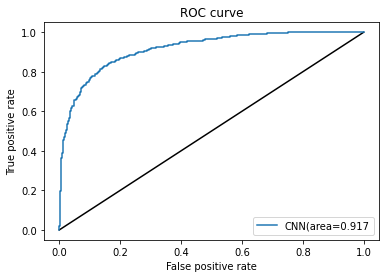

AUROC: 0.9165330000000002
Test Error: 
 Accuracy: 83.7%, Avg loss: 0.380566
Saved PyTorch Model State to model.pth

Epoch 12
-------------------------------
loss: 0.333446  [    0/ 8000]
loss: 0.387182  [ 6400/ 8000]


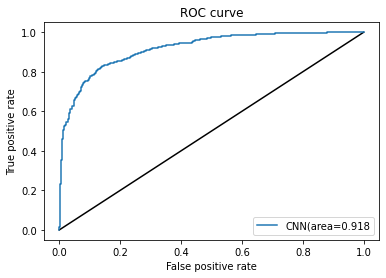

AUROC: 0.917806
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.405477

Epoch 13
-------------------------------
loss: 0.301875  [    0/ 8000]
loss: 0.197178  [ 6400/ 8000]


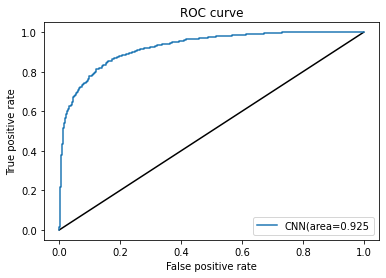

AUROC: 0.924794
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.367414
Saved PyTorch Model State to model.pth

Epoch 14
-------------------------------
loss: 0.473365  [    0/ 8000]
loss: 0.272138  [ 6400/ 8000]


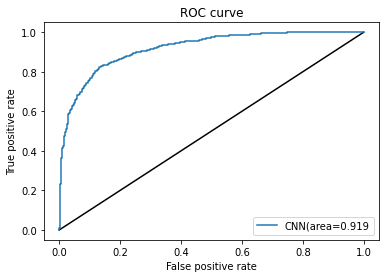

AUROC: 0.91862
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.386049

Epoch 15
-------------------------------
loss: 0.299029  [    0/ 8000]
loss: 0.229216  [ 6400/ 8000]


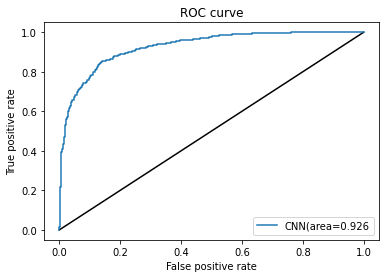

AUROC: 0.9263509999999999
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.354589
Saved PyTorch Model State to model.pth

Epoch 16
-------------------------------
loss: 0.248090  [    0/ 8000]
loss: 0.420517  [ 6400/ 8000]


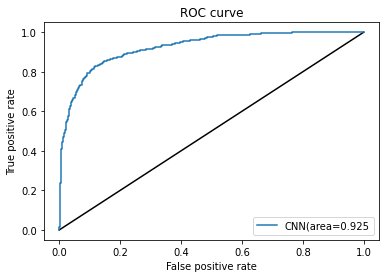

AUROC: 0.9248080000000001
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.376341

Epoch 17
-------------------------------
loss: 0.240358  [    0/ 8000]
loss: 0.144319  [ 6400/ 8000]


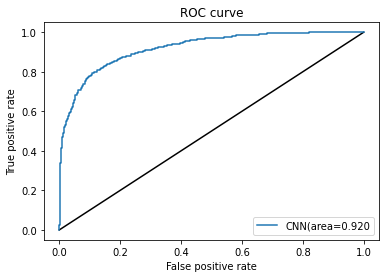

AUROC: 0.9195180000000001
Test Error: 
 Accuracy: 83.9%, Avg loss: 0.379411

Epoch 18
-------------------------------
loss: 0.263574  [    0/ 8000]
loss: 0.240602  [ 6400/ 8000]


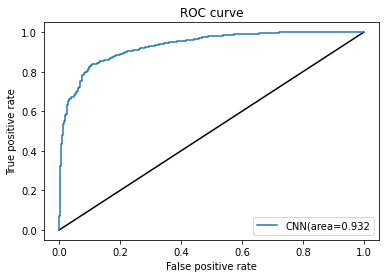

AUROC: 0.931908
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.340429
Saved PyTorch Model State to model.pth

Epoch 19
-------------------------------
loss: 0.182152  [    0/ 8000]
loss: 0.356341  [ 6400/ 8000]


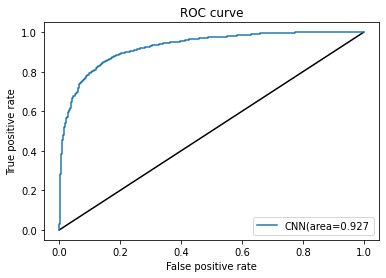

AUROC: 0.92732
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.375206

Epoch 20
-------------------------------
loss: 0.351794  [    0/ 8000]
loss: 0.212291  [ 6400/ 8000]


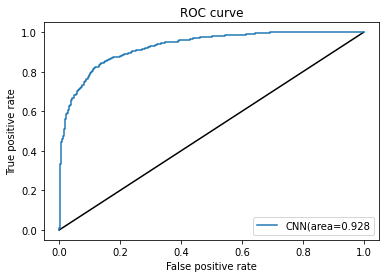

AUROC: 0.927889
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.356667

Epoch 21
-------------------------------
loss: 0.239747  [    0/ 8000]
loss: 0.202940  [ 6400/ 8000]


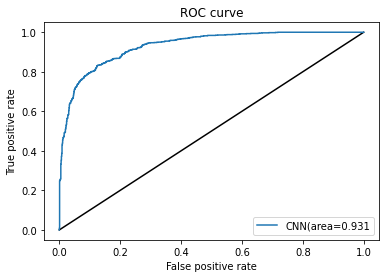

AUROC: 0.9312805000000001
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.374896

Epoch 22
-------------------------------
loss: 0.352681  [    0/ 8000]
loss: 0.247156  [ 6400/ 8000]


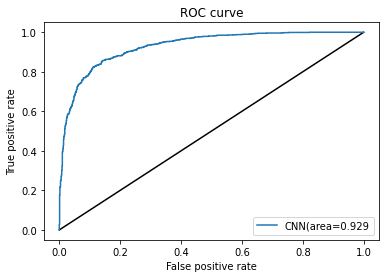

AUROC: 0.9288394999999999
Test Error: 
 Accuracy: 85.2%, Avg loss: 0.362418

Epoch 23
-------------------------------
loss: 0.228253  [    0/ 8000]
loss: 0.209537  [ 6400/ 8000]


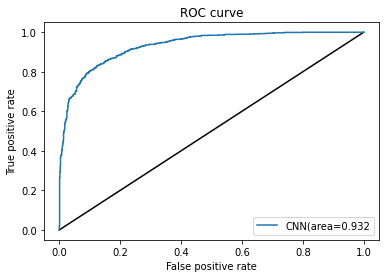

AUROC: 0.9324025
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.395253
Done!


<All keys matched successfully>

In [37]:
# Number of epochs
epochs = 40

# Variables for early stopping
min_validation_loss = 0
early_stop_counter = 0

for t in range(epochs):
    print(f"\nEpoch {t+1}\n-------------------------------")

    # Train model during epoch
    train(train_dataloader, model, loss_fn, optimizer)

    # Test model during epoch
    test(test_dataloader, model, loss_fn)

    # Determine average losses during training & testing
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    # Clear lists for next epoch
    train_losses = []
    valid_losses = []

    # If first epoch, save validation loss as current mininmum
    if t == 0:
      min_validation_loss = valid_loss

    # If validation loss is decreasing, save our model
    else:
      if valid_loss < min_validation_loss:
        torch.save(model.state_dict(), "model.pth")
        print("Saved PyTorch Model State to model.pth")
        min_validation_loss = valid_loss
        early_stop_counter = 0

      # If it's not increasing, start our counter for early stopping
      else:
        early_stop_counter += 1
        if early_stop_counter >= 5:
          break

print("Done!")

# Load the model at the point of lowest validation loss
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

Read more about [Training your model](optimization_tutorial.html).




--------------




## Saving Models
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).



In [38]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models

The process for loading a model includes re-creating the model structure and loading
the state dictionary into it.



In [39]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

This model can now be used to make predictions.



In [40]:
# classes = [
#     "T-shirt/top",
#     "Trouser",
#     "Pullover",
#     "Dress",
#     "Coat",
#     "Sandal",
#     "Shirt",
#     "Sneaker",
#     "Bag",
#     "Ankle boot",
# ]

# model.eval()
# x, y = test_data[0][0], test_data[0][1]
# with torch.no_grad():
#     pred = model(x)
#     predicted, actual = classes[pred[0].argmax(0)], classes[y]
#     print(f'Predicted: "{predicted}", Actual: "{actual}"')

Read more about [Saving & Loading your model](saveloadrun_tutorial.html).


